In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller

import warnings
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import train_test_split

from data_import import *

##### Data Import

In [2]:
oregon_data_dict = oregon_import(float_32=True)

file import: 100%|██████████| 3/3 [00:00<00:00,  4.02it/s]


In [3]:
# wa_df = oregon_data_dict['train_timeseries'].iloc[4:,:].reset_index(inplace=False, drop=True)
wa_df = oregon_data_dict['train_timeseries'].copy()
wa_df = wa_df[wa_df['fips']==41067]
wa_df.drop(columns=['fips'],inplace=True)
wa_df = wa_df.iloc[4:,:]
wa_df = wa_df.iloc[:-4,:]
wa_df['date'] = wa_df['date'].map(pd.Timestamp.timestamp)
wa_df.reset_index(inplace=True,drop=True)

In [4]:
wa_county_score_list = wa_df['score'].dropna().copy()

##### Examining data suitability for ARIMA

In [ ]:
result = adfuller(wa_county_score_list)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -5.508469614198743
p-value: 1.9969355206027656e-06


In [3]:
train_copy = oregon_data_dict['train_timeseries'].copy()
train_copy.dropna(subset=['score'], how='all', inplace=True)

In [15]:
oregon_score_list = wa_df['score'].dropna().copy()
result = adfuller(oregon_score_list)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -5.508469614198743
p-value: 1.9969355206027656e-06


In [4]:
model = ARIMA(train_copy, order=(1, 0, 1))
model_fit = model.fit()

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [ ]:


def parser(x):
	return pd.Datetime.strptime('190'+x, '%Y-%m')

series = pd.read_csv('./processed_data/oregon_train_timeseries.csv', header=0, parse_dates=[0], index_col=0, date_parser=parser)
autocorrelation_plot(series)
plt.show()

C:\Users\pears\AppData\Local\Temp\ipykernel_21744\304317978.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  series = pd.read_csv('./processed_data/oregon_train_timeseries.csv', header=0, parse_dates=[0], index_col=0)


##### Grid Search of ARIMA order values

In [5]:
only_scored_train = oregon_data_dict['train_timeseries'].copy()
only_scored_train.dropna(subset=['score'], how='all', inplace=True)

In [15]:
from statsmodels.graphics.tsaplots import plot_acf

In [6]:
train_data = pd.read_csv('.\processed_data\oregon_train_timeseries.csv',header=0, index_col=1)
train_data.drop(columns=['fips'],inplace=True)
train_data.dropna(subset=['score'], how='all', inplace=True)

ValueError: x is required to have ndim 1 but has ndim 2

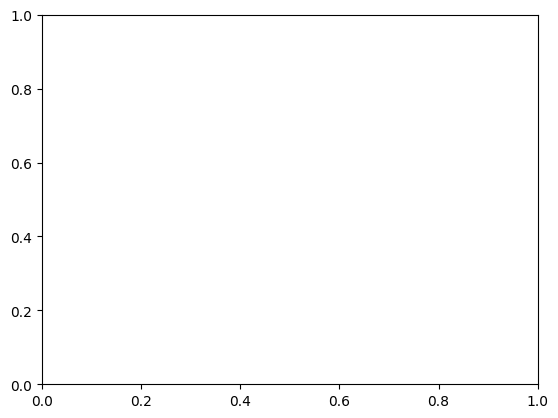

In [24]:
plot_acf(train_data)
plt.show()

In [ ]:
train_data = pd.read_csv('.\processed_data\oregon_train_timeseries.csv',header=0, index_col=1)
train_data.drop(columns=['fips'],inplace=True)
train_data.dropna(subset=['score'], how='all', inplace=True)

X = train_data.iloc[:, train_data.columns != 'score']
y = train_data.iloc[:, train_data.columns == 'score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [58]:
def county_grouped_shufflesplit(df: pd.DataFrame):
    """
    Performs group shuffle split on specified data. Groups by county via 'fips' column.
    
    Parameters
    ----------
    'df' : pd.DataFrame
        contains the data to be split. Should just be an import of csv from .\processed_data, with date as index.


    Returns
    -------
    'split_data_dict' a dict containing the shuffled split data, grouped by county.
    """
    split_data_dict = {}

    df.dropna(subset=['score'], how='all', inplace=True)

    X = df.iloc[:, (df.columns != 'score') & (df.columns != 'fips')]
    y = df.iloc[:, df.columns == 'score']
    county = df.iloc[:, df.columns == 'fips']

    gss = GroupShuffleSplit(n_splits=1, test_size=0.2)
    for train_x_index, test_x_index in gss.split(X=X,y=y, groups=county):
        X_train = X.iloc[train_x_index,:]
        X_test = X.iloc[test_x_index,:]
        y_train = y.iloc[train_x_index,:]
        y_test = y.iloc[test_x_index,:]
        county_train = county.iloc[train_x_index,:]
        county_test = county.iloc[test_x_index,:]
    
    split_data_dict['X_train'] = X_train
    split_data_dict['X_test'] = X_test
    split_data_dict['y_train'] = y_train
    split_data_dict['y_test'] = y_test
    split_data_dict['county_train'] = county_train
    split_data_dict['county_test'] = county_test

    return split_data_dict

In [59]:
grouped_train_data = pd.read_csv('.\processed_data\oregon_train_timeseries.csv',header=0, index_col=1)

split_county_data = county_grouped_shufflesplit(grouped_train_data)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X = X, y = y, test_size= 0.33)

TypeError: got an unexpected keyword argument 'X'

In [ ]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.66)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit()
		y_hat = model_fit.forecast()[0]
		predictions.append(y_hat)
		history.append(test[t])
	# calculate out of sample error
	rmse = np.sqrt(mean_squared_error(test, predictions))
	return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	# dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				# try:
				rmse = evaluate_arima_model(dataset, order)
				if rmse < best_score:
					best_score, best_cfg = rmse, order
				print('ARIMA%s RMSE=%.3f' % (order,rmse))
				# except:
					# continue
	print('Best ARIMA %s RMSE = %.3f' % (best_cfg, best_score))


# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(train_data.values, p_values, d_values, q_values)

AttributeError: 'list' object has no attribute 'score'